# Fortegra Data Challenge
Magnus Skonberg | May 21st 2023

## Irrigation Sprinkler Insurance Spec

A new potential partner is coming to us with a potential portfolio for us to work with. The portfolio is insurance for irrigation sprinklers, a type of farming equipment. They have been running this program for about 5 years and are looking for a new partner to work with them. We have an opportunity to analyze their data and recommend underwriting changes to improve the performance of their portfolio. We are targeting a loss rate of 60% or lower for any portfolio we work with. Loss ratio is defined as sum of total claims paid / sum of total premium earned, over a given time period.

The 2 datasets are: `claims.csv` with one row per claim filed and `premiums.csv` with one row per piece of equipment.

1. Clean the data how you see fit. State your assumptions. Assume that a cleaned subset of the data is better than data which is skewed, biased, or incorrect.
2.	Calculate loss ratio by state, county, number of previous claims, deductible amount, and equipment year. Explain your results and note anything you found interesting or important.
3.	Perform other pieces of EDA/analysis you think is interesting. Since time is limited, you can limit to 1-2 analyses, then list other analysis you think would be interesting to look at if you had more time.
4.	Based on the analysis you’ve done, what are some recommended changes to the underwriting of this portfolio?

## Approach

After reading in the data, the sections that follow are:

1. **Claims Data Cleaning**: Preliminary EDA, EDA & Pre-processing, Column Descriptions, Data Redundancy, Missing Data, Outliers, and Feature Creation (Number of Previous Claims)
2. **Premiums Data Cleaning**: Preliminary EDA, EDA & Pre-processing, Column Descriptions, Data Redundancy, Missing Data, and Outliers
3. **Aggregation and Loss Ratio Calculations**: State, County, General Loss Ratio, Number of Previous Claims, Deductible, and Equipment Year (Decade)
4. **Additional EDA**: Bright Spot Analysis, Summary of EDA Findings, and Additional Analyses of Interest 
5. **Conclusion**: Summary of Findings, Recommended Underwriting Changes

Along the way, I provided comments within code chunks and written explanations following code chunks / visualizations to clarify steps taken, assumptions made, and reasoning. For a more concise form of this report, please refer to the "Executive Summary".


## Read in Data

In [1]:
# import essential libraries
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime

# read in csvs
claims = pd.read_csv('claims.csv')
premiums = pd.read_csv('premiums_full.csv')

In [2]:
# verify data read in
claims.head()

,PolicyNumber,CustomerId,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate,Deductible,County,State,EquipmentYear,PolicyEffectiveDate
0,P-654-2022,419,2022-12-23,2023-01-03,Lightning-Irr,10466.75,1000,Chase,NE,1993.0,2022-11-20
1,P-3199-2022,2667,2022-12-19,2023-02-08,Lightning-Irr,4535.69,1000,Tattnall,GA,0.0,2022-03-19
2,P-1031-2022,1278,2022-12-12,2022-12-13,Claim Withdrawn,0.00,1000,Edwards,KS,0.0,2022-06-01
3,P-4890-2022,2794,2022-12-02,2022-12-08,Collision-Irr,20347.48,1000,Pawnee,KS,2022.0,2022-10-01
4,P-4102-2022,1233,2022-11-22,2022-11-29,Collision-Irr,15458.86,1000,Floyd,TX,0.0,2022-04-08


In [3]:
# verify data read in
premiums.head()

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
0,P-562-2018,3833,1,2018-03-01,2019-03-01,594,594.0,1000,36000.0,Furnas,NE,1994.0,36000.0
1,P-5085-2018,3123,1,2018-08-10,2019-08-10,7520,960.0,1000,60000.0,Castro,TX,1993.0,60000.0
2,P-5085-2018,3123,2,2018-08-10,2019-08-10,7520,1760.0,1000,110000.0,Castro,TX,2015.0,110000.0
3,P-5085-2018,3123,3,2018-08-10,2019-08-10,7520,960.0,1000,60000.0,Castro,TX,1988.0,60000.0
4,P-5085-2018,3123,4,2018-08-10,2019-08-10,7520,1760.0,1000,110000.0,Castro,TX,2014.0,110000.0


## Claims Data Cleaning

### Preliminary EDA

Prior to operating upon our data, we get to know it a bit first by inspecting the columns we have, their data types, and some of the numeric distributions / summary statistics that we're dealing with:

In [4]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PolicyNumber         2382 non-null   object 
 1   CustomerId           2382 non-null   int64  
 2   DateOfLoss           2382 non-null   object 
 3   ClaimReceivedDate    2380 non-null   object 
 4   ClaimCause           2382 non-null   object 
 5   TotalPaidToDate      2382 non-null   float64
 6   Deductible           2382 non-null   int64  
 7   County               2351 non-null   object 
 8   State                2351 non-null   object 
 9   EquipmentYear        2349 non-null   float64
 10  PolicyEffectiveDate  2382 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 204.8+ KB


In [5]:
claims.describe()

,CustomerId,TotalPaidToDate,Deductible,EquipmentYear
count,2382.000000,2382.000000,2382.000000,2349.000000
mean,2729.119228,26921.458476,1433.879093,1758.216262
std,1549.089882,49193.956944,1458.056440,652.271963
min,3.000000,0.000000,1000.000000,0.000000
25%,1423.000000,3617.772500,1000.000000,1985.000000
50%,2715.000000,9536.105000,1000.000000,1998.000000
75%,4048.500000,33155.097500,1000.000000,2009.000000
max,5375.000000,934700.000000,25000.000000,2022.000000


Based on early, light EDA of `claims` data:
* we're dealing with 2382 rows x 11 columns
* PolicyNumber is non-unique and it looks like we're missing a unique primary key (ie. claims_id)
* 7/11 columns are not missing values, whereas ClaimReceivedDate, County, State, and EquipmentYear have missing values.
* CustomerId ranges from 3 to 5375 and may not increment in a linear, predictable fashion
* TotalPaidToDate appears to have anomalous / outlier values with a range from 0 to 934700 and a median ~9.5k
* Deductibles range from 1000 to 25000 with what appears to be a clear majority of 1000. It will be worth exploring the distribution of values and any patterns / trends therein.
* EquipmentYear ranges from 0 to 2022. 0 is a nonsensical value for our context here and we'll want to re-interpret.
* date columns: DateOfLoss, ClaimReceivedDate, PolicyEffectiveDate
* possible categorical columns: ClaimCause, Deductible

### EDA & Pre-processing

We continue with our EDA (exploratory data analysis) with the intention of getting to know our data better so that we can better prepare / clean it for later use and interpretation.

**Missing values**

<AxesSubplot:>

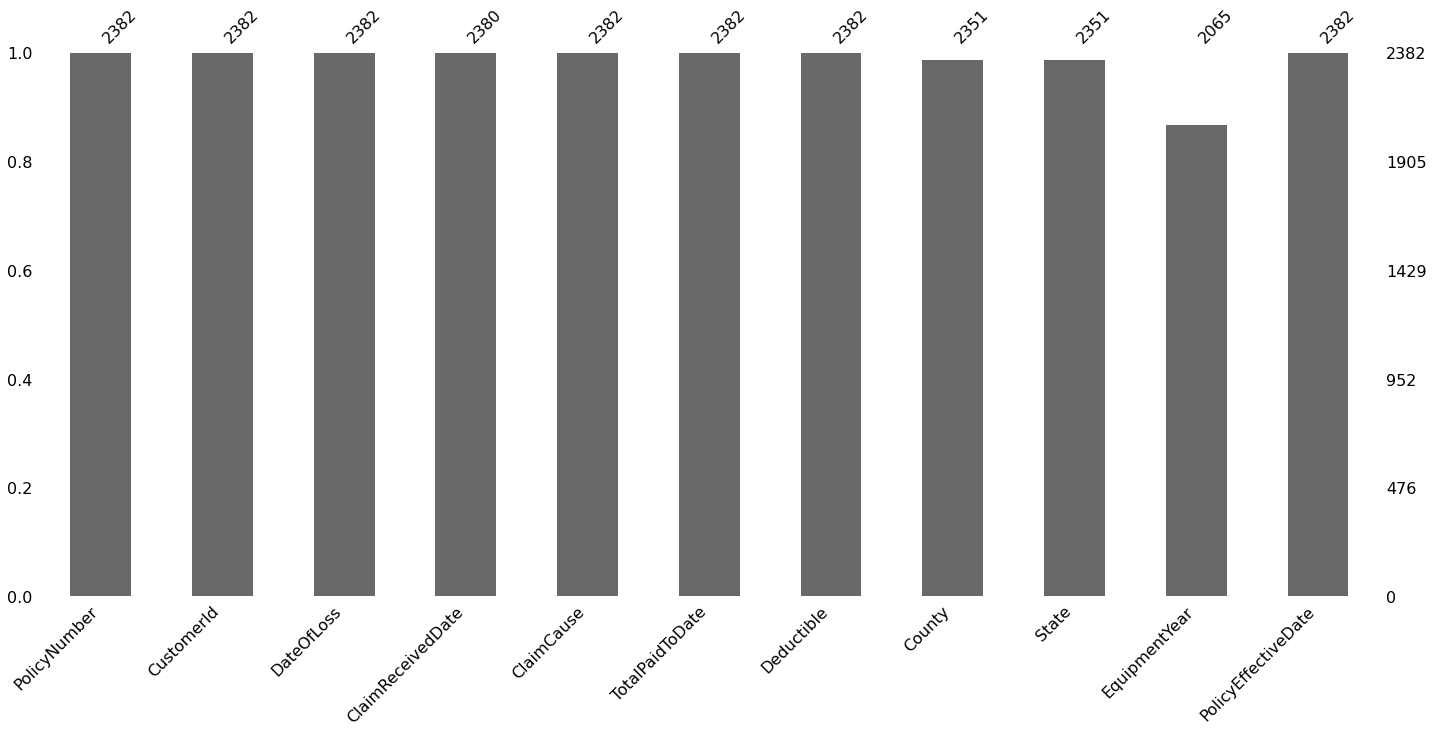

In [6]:
# Re-assign EquipmentYear 0 values to NaN
claims['EquipmentYear'].value_counts()
claims['EquipmentYear'].replace(0, np.nan, inplace=True)

# Missing values
msno.bar(claims)

The above missing data visualization, generated using the `missingno` library, highlights missing data per column as a total number and a proportion. After imputing 0s with NaNs in the EquipmentYear column, we observe that:

* ClaimReceivedData is missing 2 values, 
* County and State are missing 31 values (which are more likely than not related), and
* EquipmentYear is missing 13.3% (317 / 2382) values.

As such, *missing data is an issue and will have to be dealt with.*

**Categorical variable exploration**

From missing data we're naturally curious of what our "categorical" variable distributions look like and so we explore ClaimCause and Deductible value counts:

In [7]:
# what are the different ClaimCauses we're dealing with?
claims['ClaimCause'].value_counts()

Wind-Irr           920
Lightning-Irr      532
M&E-Irr            286
Collision-Irr      213
Claim Withdrawn     97
Collapse-Irr        88
Flood-Irr           76
Claim Denied        53
Hail-Irr            46
Theft-Irr           23
Animal-Irr          19
Fire-Irr            14
Freezing-Irr         8
Overturn-Irr         4
Vandalism-Irr        2
Vand-Irr             1
Name: ClaimCause, dtype: int64

In [8]:
# remove -Irr from ClaimCause
claims['ClaimCause'] = claims['ClaimCause'].str.replace('-Irr','')

In [9]:
# what are the different ClaimCauses we're dealing with?
claims['Deductible'].value_counts()

1000     2028
2500      225
5000       99
10000      28
25000       2
Name: Deductible, dtype: int64

The ClaimCause column is healthily spread across values: 

* the majority of claims are tied to '-Irr' at the close of the label (ie. "Lightning-Irr" - Lightning Irrigation Claim). O removed the excessive labelling ('-Irr') for sake of simpler reading.
* 'Vandalism-Irr' and 'Vand-Irr' may mean the same thing and only occur 3 times total
* we can exclude 'Claim Denied' and 'Claim Withdrawn' observations.

The Deductible column is primarily populated with value = 1000. For now, we'll carry this variable forward but we'll keep in mind that it's heavily skewed and may not carry valuable info.

**Claims without Premiums**

In [10]:
# how many claims policies also exist in premium? 1696 / (1696+251)
claims['PolicyNumber'].isin(premiums['PolicyNumber']).value_counts()

True     2084
False     298
Name: PolicyNumber, dtype: int64

There exist ~300 claims without PolicyNumbers in the premiums dataset. These claims can be excluded since they cannot be tied to a paid for policy.

**Date Exploration**

In [11]:
# how many claims were made without a policy or on the same day as opening a policy?
claims['ValidDateBool'] = claims['ClaimReceivedDate'] >= claims['PolicyEffectiveDate']
#claims['ValidDateBool'].value_counts()

# # are there any claims that came before the date of loss?
claims['DaysBetweenLossAndClaim'] = pd.to_datetime(claims['ClaimReceivedDate']).dt.date - pd.to_datetime(claims['DateOfLoss']).dt.date
#claims['DaysBetweenLossAndClaim'].sort_values()

The above code chunk was an exploration of whether we had incidence of claims being made before the policy had gone into effect as well as the days between when a loss was noted and a claim was made. Nothing noteworthy was identified.

**Distributions & Pairplots**

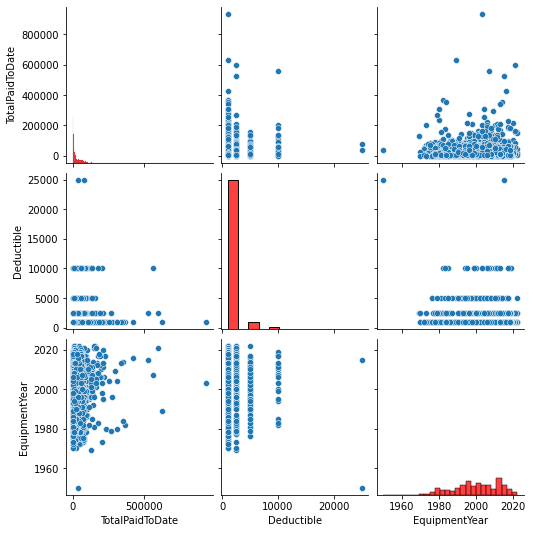

In [12]:
# remove boolean variable from consideration
factor_data = claims.loc[:, ~claims.columns.isin(['CustomerId','ValidDateBool','DaysBetweenLossAndClaim'])]

# generate pairplot
sns.pairplot(factor_data, diag_kws={'color':'red'})

Based on distributions and pairplots (of numeric columns) we can extend:
* the impression of outliers in the TotalPaidToDate column
* confirmation of Deductible as more categorical than numeric in nature
* removal of 0s from EquipmentYear is commonsensical.

### Column Descriptions

Prior to cleaning our data it's important to understand what data we're dealing with. We verify that all columns are of a reasonable type and format and provide column descriptions as follows:

* PolicyNumber: unique policy number for corresponding customer
* CustomerId: unique customer id
* DateOfLoss: date that loss was incurred on the customer's end
* ClaimReceivedDate: documented date that a claim was filed by the customer and received by our potential partner
* ClaimCause: reason for the claim and cause of the equipment damage (ie. Wind or Damage)
* TotalPaidToDate: cumulative claim amount paid to customer at date of claim filing
* Deductible: the amount the customer pays before insurance is to cover the difference
* County: county associated with customer location (ie Chase)
* State: state associated with customer location (ie. NE)
* EquipmentYear: year that corresponding piece of equipment was manufactured
* PolicyEffectiveDate: date that customer's corresponding policy came into effect

With these descriptions and our chief (loss rate) question in mind, we proceed to *actually clean* our data.

### Data Redundancy

As a next natural step, we address data redundancy. In this step we eliminate rows and/or columns if they do not provide value in addressing our question. 

Being that our primary concern is the loss ratio (claims paid / premiums earned), we make the following assumptions:

1. Claims that were denied or withdrawn can be excluded.
2. Claims without money tied to them (ie. TotalPaidToDate = 0) can be excluded.
3. Claims without matching PolicyNumbers in the premiums dataset can be excluded. Where claims are made and premiums are not paid (ie. PolicyNumber does not exist in premiums dataset), there is no policy.

In [13]:
# generate boolean for matching policy numbers in claims and premiums
claims['MatchingPolicy'] = claims['PolicyNumber'].isin(premiums['PolicyNumber'])

# Filter for valid claims
claims.drop_duplicates(inplace=True)
claims = claims[~claims['ClaimCause'].isin(['Claim Withdrawn', 'Claim Denied'])]
claims = claims[claims['TotalPaidToDate'] > 0]
claims = claims[claims['MatchingPolicy'] == True]
claims.shape

(1950, 14)

Addressing the above assumptions shedd 18% (432 / 2382) of our data resulting in a 1950 x 12 dataset.

From here, we move on to the next natural step: addressing missing data.

### Missing Data

As was visualized and noted earlier with the missigno visualization, we're dealing with missing values in the ClaimReceivedDate, County and State, and EquipmentYear columns. We'll move up the totem pole of missing data ...

**ClaimReceivedDate**

In [14]:
# Explore ClaimReceivedDate null presence
claims[claims['ClaimReceivedDate'].isna()]

# Re-assign where ClaimReceivedDate is NaN to match PolicyEffectiveDate
claims['ClaimReceivedDate'] = claims['ClaimReceivedDate'].fillna(claims['PolicyEffectiveDate'])

Earlier we'd noted and explored incidence of ClaimReceivedDate = PolicyEffectiveDate. There were 20+ incidences of it and they all followed the same pattern of this claim: all dates were equivalent. As such, I felt imputation using the existing dates based on this pattern sufficed as a solution to the missing date.

**County and State**

In [15]:
# interpret State / County missing values
claims[claims['State'].isna()] #9 observations

#Look at each instances PolicyNumber to see if we have existing data
#claims[claims['PolicyNumber'] == "P-38-2021"] 
#claims[claims['PolicyNumber'] == "P-5308-2021"] 
#claims[claims['PolicyNumber'] == "P-3330-2020"] # Dodge, NE
#claims[claims['PolicyNumber'] == "P-3921-2020"] 
#claims[claims['PolicyNumber'] == "P-3239-2020"] 
#claims[claims['PolicyNumber'] == "P-2564-2019"] 
#claims[claims['PolicyNumber'] == "P-2340-2019"] # Linclon, NE
#claims[claims['PolicyNumber'] == "P-3453-2019"] # Colfax, NE
#claims[claims['PolicyNumber'] == "P-1607-2019"] 

# Replace missing County / State (where applicable)
claims.loc[claims["PolicyNumber"] == "P-3330-2020", "County"] = 'Dodge'
claims.loc[claims["PolicyNumber"] == "P-3330-2020", "State"] = 'NE'
claims.loc[claims["PolicyNumber"] == "P-2340-2019", "County"] = 'Lincoln'
claims.loc[claims["PolicyNumber"] == "P-2340-2019", "State"] = 'NE'
claims.loc[claims["PolicyNumber"] == "P-3453-2019", "County"] = 'Colfax'
claims.loc[claims["PolicyNumber"] == "P-3453-2019", "State"] = 'NE'

# Drop missing County / State data
claims = claims[~claims['State'].isna()]

# Confirm
claims.shape

(1944, 14)

For the County and State missing data, we noticed that they were missing together, and being that there weren't that many incidences I visited it on a case-by-case basis and looked for matching policy numbers with state and county data. There were 3/9 incidences with existing PolicyNumbers so for these incidences I imputed the County and State using those listed for the same PolicyNumber. I then excluded the remaining observations being that 3 / 5 fields in question for loss ratio were missing (County, State, and EquipmentYear).

**EquipmentYear**

In [16]:
# what % of EquipmentYear values are missing?
missing_ey_claims = claims['EquipmentYear'].isna().sum()
all_ey_claims = claims['EquipmentYear'].size

# output the %
print(round(((missing_ey_claims / all_ey_claims) * 100.00),2))

12.65


~13% of the data in EquipmentYear are missing. Data gaps are hard to accept because skewed inputs lead to skewed outputs and unreliable insights. As such, we want to deal with the "garbage in" to avoid "garbage out".

To handle this, we can exclude, impute, or label & leave the missing data.

In my opinion imputation would be crude and introduce unwanted bias (ie. adding 12% of EquipmentYear values with the same value). Leaving the missing data in, on the other hand, could bias our output because there may have been a reason certain EquipmentYears were empty or marked 0. 

As such, I elect the "happy medium":

In [17]:
# Create missing claims df (for later analysis)
claims_missing = claims[claims['EquipmentYear'].isna()]

# Explore missing claims TotalPaidToDate distribution
claims_missing['TotalPaidToDate'].describe()

count       246.000000
mean      17168.750813
std       23365.268637
min         240.000000
25%        3747.010000
50%        7639.310000
75%       16876.275000
max      136545.800000
Name: TotalPaidToDate, dtype: float64

In [18]:
# Exclude claims with missing EquipmentYear data
claims = claims[~claims['EquipmentYear'].isna()]

# Explore claims TotalPaidToDate distribution
claims['TotalPaidToDate'].describe()

count      1698.000000
mean      30830.700024
std       48609.959043
min          32.930000
25%        4719.270000
50%       12482.005000
75%       40839.947500
max      627101.920000
Name: TotalPaidToDate, dtype: float64

*I elect to exclude these observations from our present analysis*, proceed with ~1700 cleaned observations, and create a `claims_missing` df (in case I decide to run a separate EDA later).

My reasoning for this decision is 2-fold:

1. I don't believe claims should be paid for irrigation equipment if equipment data hasn't been provided. Imagine putting in an auto insurance claim and not providing the make, model, year of your vehicle ...
2. the fact that the distributions differ for TotalPaidToDate provides indication that this data is different and should be treated as such. A follow up EDA on it could prove worthwhile.

In my opinion exclusion maintains the integrity of our data, creates a consistent approach (which we'll use with premiums data as well), and generates the added benefit that, with a separate missing data dataframe, we can interpret and understand the characteristics and impact of this missing data, if we so decide, as a potential follow up EDA.

### Outliers

Based on distributions and pairplots (of numeric columns) earlier we got the impression of outliers in the TotalPaidToDate column and so we'll explore these anomalous values here.

We'll aim to understand whether they're "naturally occuring" (explicable) vs. "off" (inexplicable).

**TotalPaidToDate**

<AxesSubplot:xlabel='TotalPaidToDate'>

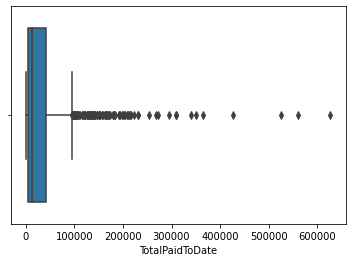

In [19]:
# Identify outlier presence
sns.boxplot(x=claims["TotalPaidToDate"])

Boxplots are a prime visualization for outliers and it's no different with this boxplot. We observe what appear to be a large volume of outliers for our variable of interest and proceed to identifying them with a combination of [the IQR method](https://builtin.com/data-science/how-to-find-outliers-with-iqr) and a flag variable. We use this same method for outlier handling later as well ...

*Simple IQR explanation: we seek to identify observations situated well above the normal range of our data. 50% of our data sits within "the range" and we flag observations 1.5x (or more) above this range.*

In [20]:
# Explore whether outliers are of "natural causes"

# perform preliminary calculations
q3 = 36295.52
q1 = 4513.58
iqr = q3 - q1

# identify outliers
claims['Outlier'] = claims['TotalPaidToDate'] > (q3 + (iqr * 1.5))

# Explore outlier data
claims_outliers = claims[claims['Outlier'] == True]

In [21]:
# what are the characteristics of these outliers?
claims_outliers.describe()

,CustomerId,TotalPaidToDate,Deductible,EquipmentYear,DaysBetweenLossAndClaim
count,135.000000,135.000000,135.000000,135.000000,135
mean,2699.511111,151838.550815,2055.555556,2003.000000,3 days 14:34:40
std,1467.996054,91043.611363,2440.842363,10.833888,5 days 01:38:24.014017384
min,23.000000,84056.000000,1000.000000,1969.000000,0 days 00:00:00
25%,1505.000000,93877.500000,1000.000000,1996.500000,1 days 00:00:00
50%,2527.000000,126471.150000,1000.000000,2005.000000,2 days 00:00:00
75%,3989.000000,169920.525000,2500.000000,2011.000000,4 days 00:00:00
max,5329.000000,627101.920000,10000.000000,2022.000000,38 days 00:00:00


In [22]:
# Deductible
claims_outliers['Deductible'].value_counts()

# EquipmentYear
claims_outliers['EquipmentYear'].value_counts()

# State
claims_outliers['State'].value_counts()

# ClaimCause
claims_outliers['ClaimCause'].value_counts()

# The above code was all pulled into one chunk for sake of conciseness (after the fact)

Wind     131
M&E        2
Flood      1
Fire       1
Name: ClaimCause, dtype: int64

In [62]:
# what's the payout across these outliers? (as a % of all claims)
round(((claims_outliers['TotalPaidToDate'].sum() / claims['TotalPaidToDate'].sum()) * 100.00),2)

# Leave anomalous TotalPaidToDate data in the dataset
#claims = claims[claims['Outlier'] != True]

39.16

What we pull from deep-diving our outliers a bit is that:

1. They're nearly all (143/147) caused by wind.
2. They're primarily lower deductible (131/147).
3. The majority of locations are in TX, KS, and NE. These states are situated in Tornado alley.
3. EquipmentYears are distributed. We might imagine more newer equipment earning a higher claim (red flag).
4. The majority of claims are made (~130/147) are made within one week of loss.

The fact that the claims are made quickly, nearly all caused by wind, and primarily situated in Tornado alley ... the data points to catastrophic-type insurance coverage (ie. irrigation equipment wrecked in a tornado). This accounts for 143/147 of the data points while the remainder (ie. Fire) can be other catastrophic-type incidents which are bound to happen when insuring businesses.

*I opt to leave these anomalous data points in as they appear to be "naturally occuring" rather than manual error.*

Before moving on, it's also worth noting that these outliers are responsible for ~39% of all claims $.

### Feature Creation

**PreviousClaims**

In [24]:
claims = claims.sort_values(by=['PolicyNumber', 'ClaimReceivedDate'])

pn_list = claims['PolicyNumber']
pn_list_2 = []
count_list = []
counter = 0

for pn in pn_list:
    if pn in pn_list_2:
        counter += 1
        count_list.append(counter)
        
    else:
        counter = 0
        count_list.append(counter)
        pn_list_2.append(pn)

# assign previous claim count to column
claims['PreviousClaims'] = count_list
claims['PreviousClaims'].describe()

count    1698.000000
mean        0.148999
std         0.444506
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: PreviousClaims, dtype: float64

In order to explore the question of loss ratio for number of existing previous claims, we needed to add a column for the number of previous claims. This was done by 

1. pre-sorting our data based on PolicyNumber and ClaimReceivedDate, 
2. incrementing through the PolicyNumber column,
3. incrementing our counter for each corresponding PolicyNumber claim,
4. assigning it to the corresponding observation (list position),
5. ensuring that counters and reset if its the 1st occurence of a PolicyNumber, and
6. assigning the resulting list to a new column in the `claims` dataframe.

The summary statistics for this new column can be observed above.

*Note: I did create a couple of additional features (ValidDateBool, DaysBetweenLossAndClaim) earlier in the EDA / data cleaning process.*

At this point we move on to cleaning the `premiums` dataset ...

## Premiums Data Cleaning

### Preliminary EDA

Just as was done with the `claims` data, we setout to get to know our `premiums` data first prior to operating upon it.
We inspect columns, data types, and numeric distributions / summary statistics:

In [25]:
premiums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82074 entries, 0 to 82073
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PolicyNumber          82074 non-null  object 
 1   CustomerId            82074 non-null  int64  
 2   Loc                   82074 non-null  int64  
 3   PolicyEffectiveDate   82074 non-null  object 
 4   PolicyExpirationDate  82074 non-null  object 
 5   PolicyPremium         82074 non-null  int64  
 6   LocationPremium       82074 non-null  float64
 7   Deductible            82074 non-null  int64  
 8   LocValue              82074 non-null  float64
 9   County                82074 non-null  object 
 10  State                 82074 non-null  object 
 11  Equip Year            81991 non-null  float64
 12  Equip Value           81991 non-null  float64
dtypes: float64(4), int64(4), object(5)
memory usage: 8.1+ MB


In [26]:
premiums.describe()

,CustomerId,Loc,PolicyPremium,LocationPremium,Deductible,LocValue,Equip Year,Equip Value
count,82074.000000,82074.000000,82074.000000,82074.000000,82074.000000,82074.000000,81991.000000,81991.000000
mean,2699.605527,5.843519,15136.601189,1184.908715,1953.566294,66160.457189,1596.146004,66158.034443
std,1533.097870,8.537487,19310.681693,834.234769,2635.945986,39272.573106,806.396981,39270.491416
min,0.000000,1.000000,250.000000,-62.165052,1000.000000,0.000000,0.000000,0.000000
25%,1411.000000,1.000000,4086.000000,579.002984,1000.000000,43000.000000,1979.000000,43000.000000
50%,2701.000000,3.000000,8820.000000,1205.000000,1000.000000,72000.000000,1997.000000,72000.000000
75%,3990.000000,7.000000,18012.000000,1609.095173,1000.000000,85868.000000,2009.000000,85814.000000
max,5380.000000,126.000000,247802.000000,28612.223724,25000.000000,300000.000000,19870.000000,300000.000000


Based on early, light EDA of `premiums` data:
* we're dealing with 82074 rows x 13 columns
* PolicyNumber is non-unique and it looks like we're missing a unique primary key (ie. premiums_id)
* 11/13 columns are not missing values, whereas Equip Year and EquipValue have missing values.
* Loc appears to indicate separate locations under the same policy
* I hypothesize that PolicyPremium and LocationPremium are related
* LocationPremium appears to have anomalous / outlier values with a range from -62 (?) to 28612 and a median ~1.2k
* Deductibles range from 1000 to 25000 with what appears to be a clear majority of 1000.
* Equip Year (equivalent to EquipmentYear from `claims` data) ranges from 0 to 2022. 0 is a nonsensical value for our context here and we'll want to re-interpret.
* LocValue and EqupValue have the same values, thus EquipValue (with some missing values) can be dropped
* date columns: PolicyEffectiveDate, PolicyExpirationDate
* possible categorical columns: Deductible

### EDA & Pre-processing

We continue with our EDA (exploratory data analysis):

**Missing values**

<AxesSubplot:>

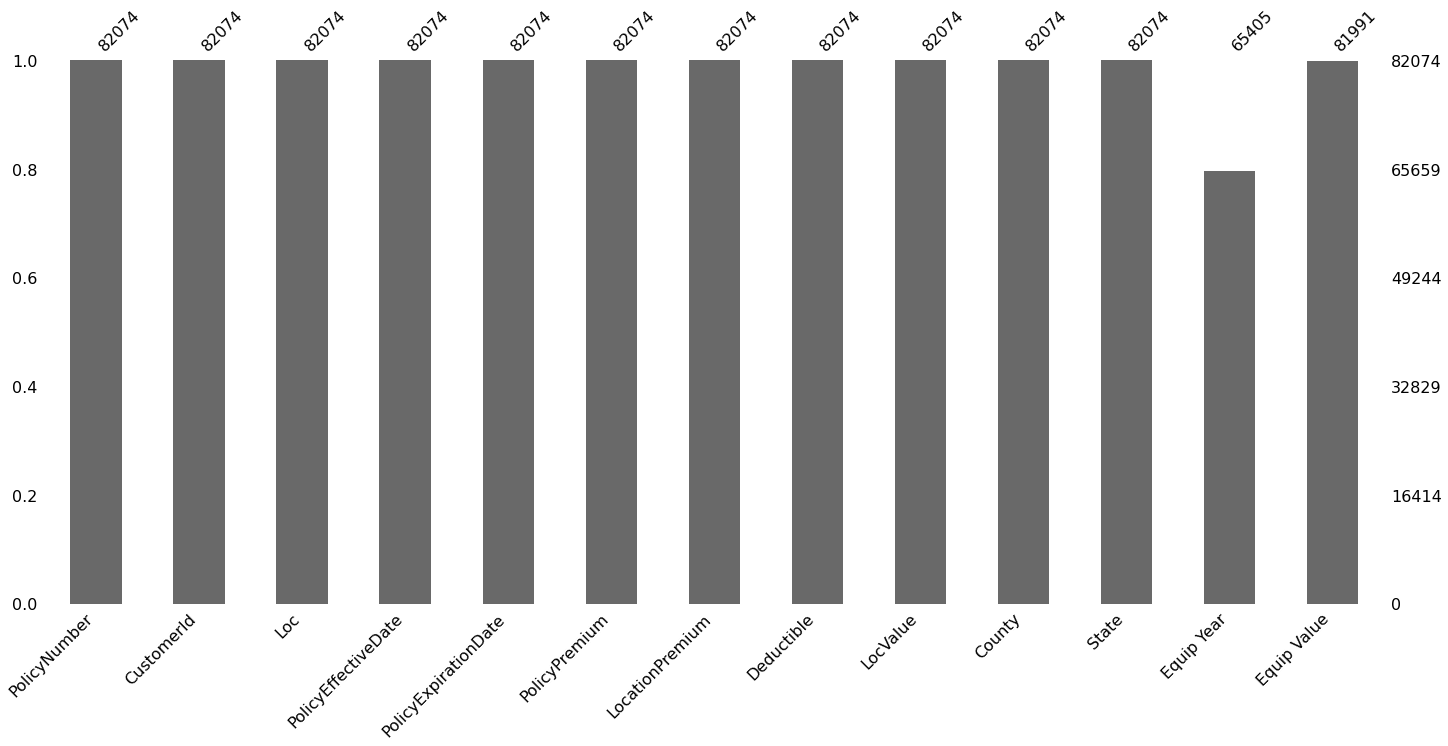

In [27]:
# Replace Equip Year 0s with NaNs
premiums['Equip Year'].replace(0, np.nan, inplace=True)

# Missing values
msno.bar(premiums)

The above missing data visualization, generated using the `missingno` library, highlights missing data per column as a total number and a proportion. After imputing Equip Year 0s with NaNs, we observe that:

* Equip Value is missing 83 values and
* Equip Year, once we've accounted for 0 values, is missing 18.9% (16669 / 82074) of values

As such, *missing data is an issue and will have to be dealt with.*

**Categorical variable exploration**

In [28]:
premiums['Deductible'].value_counts()

1000     61977
2500      9982
5000      7187
10000     2382
25000      546
Name: Deductible, dtype: int64

The Deductible value counts for the `premiums` dataset appear to be consistent with those of the `claims` dataset. With a greater proportion allocated to lower Deductibles. Typically the lower the deductible, the higher the premium. This is to be seen / confirmed later ...

**Distributions & pair plots**

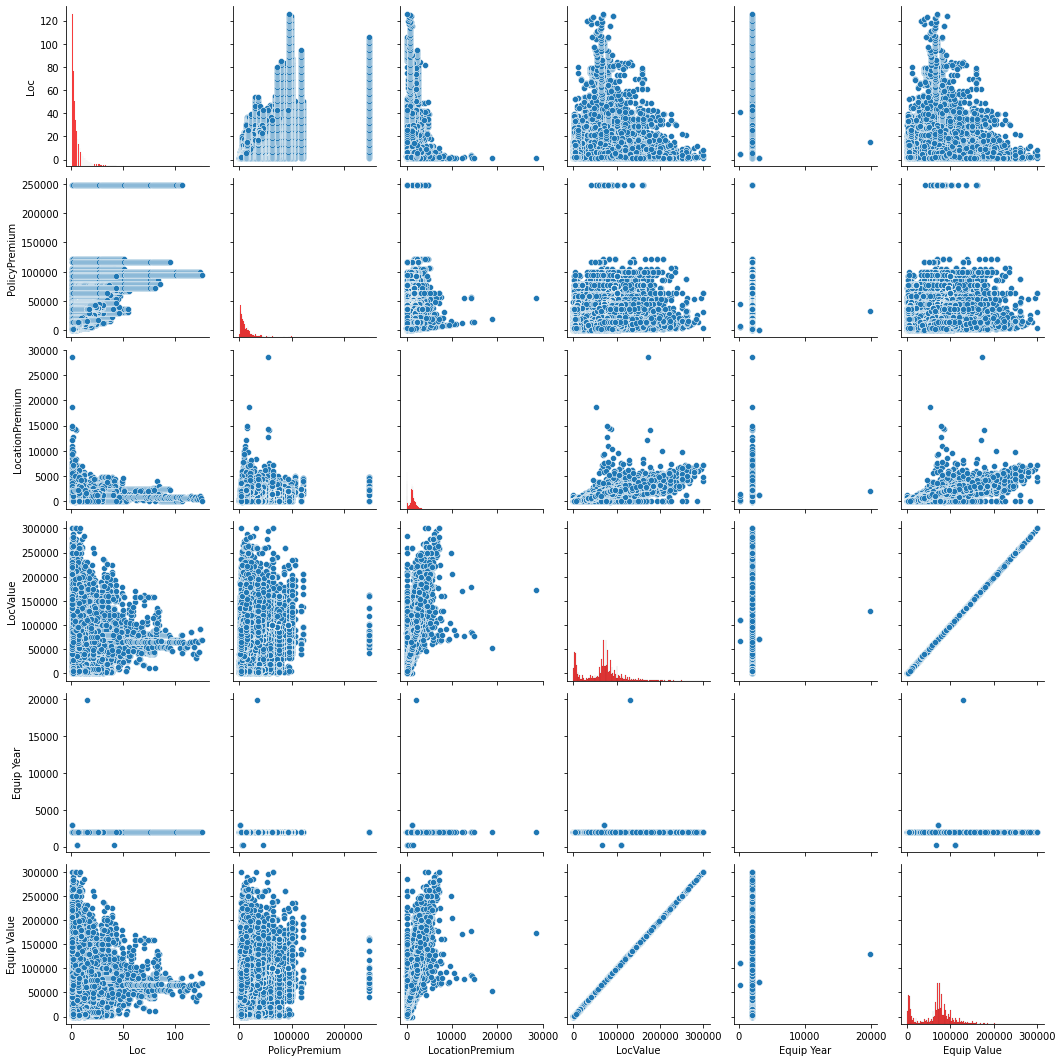

In [29]:
# Remove factor / id variables from consideration
factor_data = premiums.loc[:, ~premiums.columns.isin(['CustomerId', 'Deductible'])]

# Generate pairplot
sns.pairplot(factor_data, diag_kws={'color':'red'})

Based on distributions and pairplots (of numeric columns) we can extend:
* the impression of outliers in all distributions
* redundancy between LocValue and EquipValue. Their scatterplots are perfectly correlated.
* positive correlation between PolicyPremium and LocationPremium
* the need to address 0 values and correct typos for EquipYear

### Column Descriptions

To ensure our data is consistent between `claims` and `premiums` we re-name "Equip Year" to "EquipmentYear":

In [30]:
# rename Equip Year to match claims
premiums.rename(columns={"Equip Year": "EquipmentYear"},inplace=True)
#premiums.columns

With columns properly names, we take a moment to understand what we're looking at. We verify that all columns are of a reasonable type and format and provide column descriptions as follows:

* PolicyNumber: unique policy number for corresponding customer
* CustomerId: unique customer id
* Loc: location identifier for corresponding customer / policy
* PolicyEffectiveDate: date that corresponding policy went into effect
* PolicyExpirationDate: date that corresponding policy ceased to be in effect
* PolicyPremium: premium, across all locations and pieces of equipment, for corresponding policy
* LocationPremium: location-specific premium for corresponding policy
* Deductible: the amount the customer pays before insurance is to cover the 
* LocValue: valuation of corresponding location / equipment
* County: county associated with customer location (ie. Chase)
* State: state associated with customer location (ie. NE
* EquipmentYear: year that corresponding piece of equipment was manufactured
* Equip Value: valuation of corresponding location / equipment. *Column to be dropped.*

With these descriptions and our chief (loss rate) question in mind, we proceed to *actually clean* our data.

### Data Redundancy

As a next natural step, we address data redundancy. In this step we eliminate rows and/or columns if they do not provide value in addressing our question. 

Being that our primary concern is the loss ratio (claims paid / premiums earned), we make the following assumptions:

1. Duplicate observations are to be excluded.
2. The Equip Value column is to be dropped.
3. Pieces of equipment (observations) without a positive LocationPremium and LocValue are to be excluded. A premium must be charged and equipment must have some value for the policy to be considered valid.


In [31]:
# De-dupe data
premiums = premiums.drop_duplicates()

# Drop EquipValue since its values are identical to LocValue
#(premiums['LocValue'] == premiums['Equip Value']).sum()
premiums.drop(columns=['Equip Value'],inplace=True)

# drop LocationPremium <= 0
premiums = premiums[premiums['LocationPremium'] > 0] #premium must be charged for our consideration
premiums = premiums[premiums['LocValue'] > 0] #equipment must have some value for a policy / our consideration

premiums.shape

(77893, 12)

Addressing the above assumptions shed 5% (4181 / 82074) of our data resulting in a 77983 x 12 dataset.

From here, we move on to the next natural step: addressing missing data.

### Missing Data



**EquipmentYear**

First, we correct the typos we observed earlier in the column. Then, we set out to remedy the missing values:

In [32]:
# Replace EquipmentYear typos
premiums['EquipmentYear'].replace(220, 2020, inplace=True) #assumption 220 was a typo for 2020
premiums['EquipmentYear'].replace(19870, 1987, inplace=True)
premiums['EquipmentYear'].replace(2989, 1989, inplace=True)

With typos corrected, we set out to understand the magnitude of missigness within the column:

In [33]:
# what % of EquipmentYear values are missing?
missing_ey_prems = premiums['EquipmentYear'].isna().sum()
all_ey_prems = premiums['EquipmentYear'].size

# output the %
print(round(((missing_ey_prems / all_ey_prems) * 100.00),2))

18.36


~18% of the data in EquipmentYear are missing. To avoid skewed inputs leading to skewed outputs we can exclude, impute, or label & leave the missing data.

For sake of consistency and for the same reasons mentioned earlier, I elect the "happy medium":

In [34]:
# Create missing premiums df (for later analysis)
prems_missing = premiums[premiums['EquipmentYear'].isna()]

# Explore missing premiums LocationPremium distribution
prems_missing['LocationPremium'].describe()

count    14299.000000
mean       161.239431
std        245.736056
min          2.152140
25%         49.945422
50%         89.000000
75%        170.844378
max       6246.465412
Name: LocationPremium, dtype: float64

In [35]:
# Exclude premiums with missing Equip Year data
premiums = premiums[~premiums['EquipmentYear'].isna()]

# Explore missing premiums LocationPremium distribution
premiums['LocationPremium'].describe()

count    63594.000000
mean      1483.732309
std        694.539686
min         16.985256
25%       1120.000000
50%       1353.000000
75%       1754.511652
max      28612.223724
Name: LocationPremium, dtype: float64

For reasons mentioned earlier (during the claims section): **I elect to exclude these observations from our present analysis**, proceed with 63594 cleaned observations, and create a `prems_missing` df (in case I decide to run a separate EDA later).

### Outlier Handling

If we consider the earlier distributions, we notice that outliers are present for Loc, PolicyPremium, LocationPremium, and LocValue:
* Loc identifies a unique customer location and so we will not consider it,
* PolicyPremium is the sum of corresponding LocationPremiums and so we also will not consider it,
* As such we're left to consider LocationPremium and LocValue. We might assume that they're correlated since a higher premium would be expected on more expensive of equipment.

Let's explore!

<AxesSubplot:xlabel='LocationPremium'>

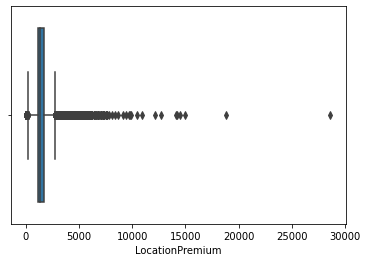

In [36]:
# Identify outlier presence
sns.boxplot(x=premiums["LocationPremium"])

<AxesSubplot:xlabel='LocValue'>

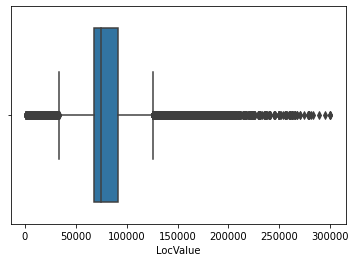

In [37]:
# Identify outlier presence
sns.boxplot(x=premiums["LocValue"])

Both box plots give the *impression* of major outlier issues.

On the flip side, these distributions may also make sense considering the irrigation sprinkler equipment we're insuring could cover a breadth of values (LocValue). As such, a better indication of an outlier here would be to take the combination of these variables to understand where our premiums do not make sense.

To ensure the validity of this approach, let's consider a scatter plot of the two variables:

<AxesSubplot:xlabel='LocValue', ylabel='LocationPremium'>

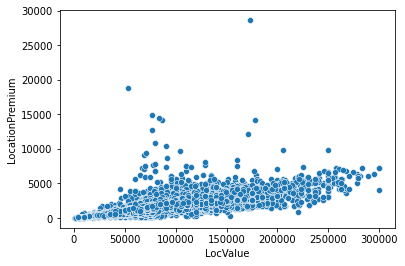

In [38]:
sns.scatterplot(data=premiums,x="LocValue",y="LocationPremium")

Yes indeed, they are positively correlated. While correlation doesn't necessarily mean causation, we can tease out outliers using the combination of these two variables.

Our guiding question being: *What variables have disproportionately high premiums for the value of equipment in question?*

We'll create a proportion variable based on LocationPremium / LocValue and fish out instances where resulting values are far out of range and premiums far outpace equipment values.

In [39]:
# Generate column to calculate proportion of premium vs. equipment value
premiums['PremValProp'] = ((premiums['LocationPremium'] / premiums['LocValue']) * 100.00)
premiums["PremValProp"].describe()

count    63594.000000
mean         1.824581
std          0.481706
min          0.120621
25%          1.600000
50%          1.650667
75%          2.000000
max         35.095327
Name: PremValProp, dtype: float64

In [40]:
# perform preliminary calculations
q3 = 2
q1 = 1.6
iqr = q3 - q1

# identify outliers
premiums['Outlier'] = premiums['PremValProp'] > (q3 + (iqr * 1.5))

# Explore outlier data
premiums_outliers = premiums[premiums['Outlier'] == True]

In [41]:
# what are the characteristics of these outliers?
premiums_outliers.describe()
#premiums_outliers['PremValProp'].hist(bins=50)

,CustomerId,Loc,PolicyPremium,LocationPremium,Deductible,LocValue,EquipmentYear,PremValProp
count,2243.000000,2243.000000,2243.000000,2243.000000,2243.000000,2243.000000,2243.000000,2243.000000
mean,2961.687026,6.625947,31521.788676,2713.813962,1973.918859,85970.386982,2001.324565,3.183311
std,1646.421250,11.814829,50523.186568,1453.439517,2122.657627,31520.349977,12.470012,1.337032
min,21.000000,1.000000,500.000000,57.906719,1000.000000,2000.000000,1971.000000,2.600000
25%,1454.000000,1.000000,8125.000000,2038.646178,1000.000000,70000.000000,1994.000000,2.699552
50%,3172.000000,3.000000,14729.000000,2467.666667,1000.000000,80886.000000,2001.000000,2.849872
75%,4392.000000,6.000000,30080.500000,3041.939105,2500.000000,98000.000000,2012.000000,3.187381
max,5358.000000,95.000000,247802.000000,28612.223724,10000.000000,264150.000000,2023.000000,35.095327


*We're dealing with ~3.5% (2243 / 63594) outliers.* When we consider the distribution of outliers in PremValProp (LocationPremium/LocValue) it becomes obvious that some outliers are far worse offenders than others.

*I opt to remove these anomalous data points since the difference in distribution is inexplicable and they appear to be manual error rather than "naturally occuring".*

In [42]:
# Explore corresponding variable counts
#premiums_outliers['Loc'].value_counts()
#premiums_outliers['Deductible'].value_counts()
#premiums_outliers['Equip Year'].value_counts()
#premiums_outliers['State'].value_counts()

# Remove outliers
premiums = premiums[premiums['Outlier'] != True]

## Aggregation & Loss Ratio Calculations

**Condition for merging dataframes**

Earlier, during the `claims` data cleaning section, we filtered the Claims dataset for PolicyNumbers shared with the Premiums dataset. This was important because it filtered for valid, paid-for policies. 

As such, we can proceed to aggregate and seek insights for different "loss ratio cuts" of our data: state, county, number of previous claims, deductible and equipment year.

### State-level

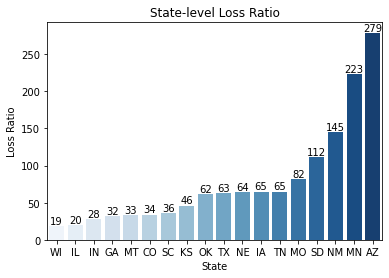

In [43]:
# Claims
st_claim_s = claims.groupby(['State'])['TotalPaidToDate'].sum()
st_claim_df = st_claim_s.reset_index() # convert series to df

# Premiums
st_prem_s = premiums.groupby(['State'])['LocationPremium'].sum()
st_prem_df = st_prem_s.reset_index() # convert series to df

# Merge dfs
state_agg = st_claim_df.merge(st_prem_df, how='inner', on='State')

# Calculate loss ratio
state_agg['Loss Ratio'] = round(((state_agg['TotalPaidToDate'] / state_agg['LocationPremium']) * 100.00),0)
state_agg.sort_values(by=['Loss Ratio'], inplace=True)
#state_agg

# Visualize relationship
ax = sns.barplot(data=state_agg, x='State', y='Loss Ratio', palette = "Blues")
ax.set(title='State-level Loss Ratio') #set title
for i in ax.containers: #specify data labels
    ax.bar_label(i,)

This state visualization provides, at a high level, a read on the states where our new potential partner is faring well and not so well with regard to claims paid  vs. premiums earned over the 5 year period we're considering. From the above visualization we can extend:

* Very favorable loss ratio (x < 40): WI, IL, IN, GA, MT, CO, SC
* Favorable loss ratio (40 < x < 60): KS
* In-range loss ratio (x ~ 60): OK, TX, NE, IA, TN
* High loss ratio (80 < x < 200): MO, SD, NM
* Very high loss ratio (x > 200): MN, AZ

*What does this mean? What can we do with this information?*

Where the loss ratio is favorable, we can study customer profiles and policy types to bring in more of the type of business that works for our irrigation sprinkler insurance partner and where the loss ratio is less than favorable we also want to study customer profiles and policy types to understand what we want to avoid and weed out of our portfolio. 

If the upside is limited in a state, we may consider ceasing business / policies whereas if the upside is great, we may consider expanding business / policies. The intent is to increase portfolio profitability for our potential client and this is done by optimizing their loss ratio.

*Additional note*

If we reference the table above the bar chart, we'll observe that certain states make up a larger portion of the total portfolio. NE, KS, and TX are the largest earners in the portfolio. If we were to optimize loss ratio in these states it would have the largest impact on our customer's business. The good news is that one state (KS) already has a favorable loss ratio while the other two (TX, NE) are very close. With some relatively minor improvements to their policy underwriting we can have all 3 of our customer's largest operations in the black :) If we recall from earlier in the analysis, the majority of anomalous claims occured in these states (in Tornado Alley) and so one lever to pull on to improve the loss ratio would be to either stop cover major wind damage / catastrophic type insurance or increasing the premiums to the point of bringing these states to a more favorable loss ratio.

### County-level

In [44]:
# Claims
co_claim_s = claims.groupby(['County'])['TotalPaidToDate'].sum()
co_claim_df = co_claim_s.reset_index() # convert series to df

# Premiums
co_prem_s = premiums.groupby(['County'])['LocationPremium'].sum()
co_prem_df = co_prem_s.reset_index() # convert series to df

# Merge dfs
county_agg = co_claim_df.merge(co_prem_df, how='inner', on='County')

# Calculate loss ratio
county_agg['Loss Ratio'] = (county_agg['TotalPaidToDate'] / county_agg['LocationPremium']) * 100.00
county_agg.sort_values(by=['Loss Ratio'], inplace=True)
#county_agg

# Visualize relationship
## what would be the best way to visualize this relationship with 243 rows?
## one option: only consider top 10 vs. bottom 10
#county_agg.shape

# Generate loss ratio categorization
loss_ratio_list = []

for lr in county_agg['Loss Ratio']:
    if lr < 40:
        loss_ratio_list.append('Very favorable')
    elif 40 <= lr < 60:
        loss_ratio_list.append('Favorable')
    elif 60 <= lr < 80:
        loss_ratio_list.append('Less favorable')
    elif 80 <= lr < 200:
        loss_ratio_list.append('Unfavorable')
    elif lr > 200:
        loss_ratio_list.append('Very unfavorable')

# Assign loss ratio categorizations
county_agg['Loss Ratio Category'] = loss_ratio_list

county_agg["Loss Ratio Category"].value_counts()

Very favorable      96
Unfavorable         46
Favorable           35
Very unfavorable    25
Less favorable      25
Name: Loss Ratio Category, dtype: int64

Being that 227 counties were under consideration, I opted to categorize and aggregate the data based on loss ratio. What I found was:

* 42.2% (96 / 227) of counties had a "Very favorable" (x < 40) loss ratio
* 15.4% (35 / 227) of counties had a "Favorable" (40 <= x < 60) loss ratio
* 11.0% (25 / 227) of counties has a "Less favorable" (60 <= x < 80) loss ratio
* 20.3% (46 / 227) of counties had an "Unfavorable" (80 < x < 200) loss ratio
* 11.0% (25 / 227) of counties had a "Very unfavorable" (x > 200) loss ratio

*What does this mean? What can we do with this information?*

In the majority of counties (57.6%) where the loss ratio was 60% or lower, we can continue operations as is and remain profitable. It might also be advisable to study the policy and customer characteristics in these counties to better understand what's working in order to emulate the "bright spots" in other counties and build upon this success.

In 31.3% of counties, we can either restructure the premiums to bring the loss ratio under 60, or, if customers are unwilling to adapt to our needs, we can close operations. Prior to doing so though, it would be advisable to make a study of policies and customer profiles to better understand why our loss ratios higher in these counties.

With the remaining 11% of counties where the loss ratio is less favorable, slight adjustments could bring the loss ratio under 60%. This could be as simple as restructuring premiums or cutting customers where loss ratios are above the desired ratio and / or expanding business with customer where the loss ratios are more favorable.

### General Loss Ratio

In [63]:
# Claims
pn_claim_s = claims.groupby('PolicyNumber').agg(TotalPaid=('TotalPaidToDate', np.sum), PrevClaims=('PreviousClaims',np.max))
pn_claim_df = pn_claim_s.reset_index() # convert series to df

# Premiums
pn_prem_s = premiums.groupby('PolicyNumber')['LocationPremium'].sum()
pn_prem_df = pn_prem_df = pn_prem_s.reset_index() # convert series to df

# Merge dfs
pn_agg = pn_claim_df.merge(pn_prem_df, how='inner', on='PolicyNumber')

# what's the business' loss ratio? (for customers that file claims)
pn_agg['Loss Ratio'] = round(((pn_agg['TotalPaid'] / pn_agg['LocationPremium']) * 100.00),0)
pn_agg.sort_values(by=['Loss Ratio'], inplace=True)
round(((pn_agg['TotalPaid'].sum() / pn_agg['LocationPremium'].sum()) * 100.00),2) #48823719 / 14557147

335.39

En route to properly aggregating our data we explore the question of *what's the portfolio's loss ratio? (for customers that file claims)*

**335.4%**

As a next natural step, we consider the overall business loss ratio:

In [65]:
# what's the business' loss ratio? (overall)
round(((claims['TotalPaidToDate'].sum() / premiums['LocationPremium'].sum()) *100.00),2)

59.31

*What's the overall portfolio loss ratio?*

**59.3**

This is on par with the type of portfolio we'd work (sub 60% loss ratio), and later we'll explore optimizing this ratio even further.

With that said, when a customer does file a claim, the loss ratio is well beyond comfort. Fortunately our irrigation portfolio has many customers that do not file claims and merely pay their premium but it's still important to have noted this and recognized that in general it's bad for business to lose out on $ for services rendered. 

Even if a customer files claims, the policies (and premiums) should be formulated to protect the rest of the business by maintaining a relatively favorable loss ratio. This high level aggregation tells me that, by and large, this portfolio has to charge more for their premiums.

### Number of Previous Claims

Let's continue exploring this same question based on the # of previous claims:

In [67]:
# Group by PrevClaims
pc_s = pn_agg.groupby('PrevClaims').agg(ClaimsPaid=('TotalPaid', np.sum), PremiumsEarned=('LocationPremium',np.sum))
pc_agg = pc_s.reset_index() # convert series to df

# Calculate loss ratio
pc_agg['Loss Ratio'] = round(((pc_agg['ClaimsPaid'] / pc_agg['PremiumsEarned']) * 100.00),0)
pc_agg.sort_values(by=['Loss Ratio'], inplace=True)

pc_agg


,PrevClaims,ClaimsPaid,PremiumsEarned,Loss Ratio
5,5,76199.23,1.167940e+05,65.0
3,3,47275.74,7.212600e+04,66.0
0,0,35664848.21,1.129484e+07,316.0
1,1,9215452.49,2.471547e+06,373.0
4,4,529979.30,8.567501e+04,619.0
2,2,3289964.73,5.161666e+05,637.0


[Text(0.5, 1.0, 'Loss Ratio Based on Number of Previous Claims')]

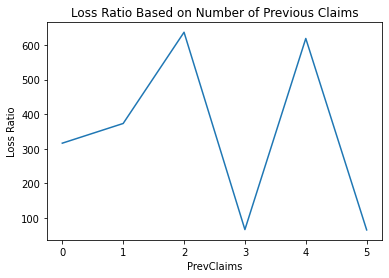

In [47]:
# Visualize relationship
ax = sns.lineplot(data=pc_agg, x='PrevClaims', y='Loss Ratio', palette = "Blues")
ax.set(title='Loss Ratio Based on Number of Previous Claims') #set title

From the above visualization we observe:
* "Very unfavorable" (x > 200) loss ratios where the policy had 0, 1, 2, and 4 previous claims and
* "Less favorable" (60 <= x < 80) loss ratios where the policy had 3 or 5 previous claims.

On the surface this is difficult to interpret. It's a non-linear relationship. With that said there are a couple of key takeaways:
1. At large, when customers file claims it leads to unfavorable loss ratios.
2. The loss ratio initally climbs with the number of claims, it then troughs, climbs again, and troughs a second time.

*What does this mean? What can we do with this information?*

At large, when customers file claims it leads to unfavorable loss ratios. 

It may be expected in providing insurance that out-of-the-ordinary events do occur and losses may occur for a small subset of customers a small % of the time, but losses cannot be incurred at the moment a claim is filed and for all manner of claims thereafter.

This calls for a complete re-assessment and re-build of the portfolio's handling of claims, premiums, and the relationship between the two as the number of previous claims increase. 

We'd want to see two changes on this visualization after revamping the portfolio's handling of claims. We'd want to see a smaller initial spike in loss ratio (ie. to 200 rather than 300+) and thereafter we'd want to see the loss ratio decrease as premiums are increased on customers filing multiple claims.

This would call for progressive premiums and proactive initial premium pricing. We can deep dive customers that are filing claims to proactively charge proper premiums to subsets of customers more likely to make claims (and larger claims). Additionally, the company can implement a progressive premiums scheme so that as a customer files more claims, their premiums climb as well.

### Deductible-level

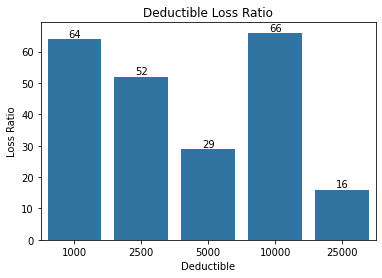

In [48]:
# Deductible aggregation
ded_claim_s = claims.groupby(['Deductible'])['TotalPaidToDate'].sum()
ded_claim_df = ded_claim_s.reset_index() # convert series to df

# Deductible aggregation
ded_prem_s = premiums.groupby(['Deductible'])['LocationPremium'].sum()
ded_prem_df = ded_prem_s.reset_index() # convert series to df

# Merge dfs
ded_agg = ded_claim_df.merge(ded_prem_df, how='inner', on='Deductible')

# Calculate loss ratio
ded_agg['Loss Ratio'] = round(((ded_agg['TotalPaidToDate'] / ded_agg['LocationPremium']) * 100.00),0)
ded_agg.sort_values(by=['Loss Ratio'], inplace=True)

# Visualize relationship
ax = sns.barplot(data=ded_agg, x='Deductible', y='Loss Ratio', color='tab:blue')
ax.set(title='Deductible Loss Ratio') #set title
for i in ax.containers: #specify data labels
    ax.bar_label(i,)

When we consider the 5 levels of deductible, we observe:

* "Very favorable" (x < 40) loss ratios for 5000 and 25000 dollar deductibles,
* "Favorable" (40 <= x < 60) loss ratio for 2500 dollar deductible, and
* "In range" (x ~ 60) loss ratio for 1000 and 10000 dollar deductibles.

*What does this mean? What can we do with this information?*

The majority (3/5) of deductible levels provide positive loss ratios, while the remaining 2/5 have slight gains to be made in order to cross the positive loss ratio threshold. 

Being that 1000 dollar deductibles make up the largest % of the portfolio, I'd recommend starting there for optimization.

I'd make a study of the customer, policy, and equipment characteristics in the groups with very favorable loss ratios (ie. 5000 dollar deductible) and the customers, policies, and equipment characteristics within the 1000 dollar deductible group that also have very favorable loss ratios and I'd aim to emulate positive markers while red-flagging customers with the most unfavorable loss ratios.

We could restructure these unfavorable loss ratio customer's policies so that their premiums are higher which would bring their loss ratios in-line or, if they're unwilling, we can cut them loose and save on the lost $. 

With customers with favorable loss ratios, we can seek to expand service with them directly and/or with customers like them. We can offer service to more locations, across a broader portfolio of equipment, etc. with the wishes that we could expand the diameter of the "bright spot" in our portfolio.

### Equipment Year-level (Decade)

In [49]:
# Claims
ey_claim_s = claims.groupby(['EquipmentYear'], dropna=False)['TotalPaidToDate'].sum()
ey_claim_df = ey_claim_s.reset_index() # convert series to df

# Premiums
ey_prem_s = premiums.groupby(['EquipmentYear'], dropna=False)['LocationPremium'].sum()
ey_prem_df = ey_prem_s.reset_index() # convert series to df

# Merge dfs
ey_agg = ey_claim_df.merge(ey_prem_df, how='inner', on='EquipmentYear')

# Calculate loss ratio
ey_agg['Loss Ratio'] = (ey_agg['TotalPaidToDate'] / ey_agg['LocationPremium']) * 100.00
ey_agg.sort_values(by=['EquipmentYear'], inplace=True)

#ey_agg #commented out for sake of conciseness

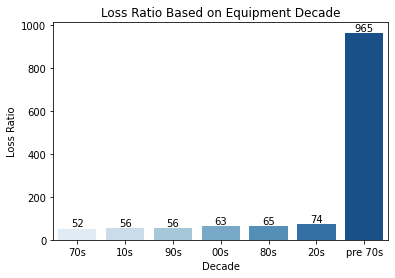

In [50]:
# Generate loss ratio categorization
decade_list = []

for year in ey_agg['EquipmentYear']:
    if year < 1970:
        decade_list.append('pre 70s')
    elif 1970 <= year < 1980:
        decade_list.append('70s')
    elif 1980 <= year < 1990:
        decade_list.append('80s')
    elif 1990 <= year < 2000:
        decade_list.append('90s')
    elif 2000 <= year < 2010:
        decade_list.append('00s')
    elif 2010 <= year < 2020:
        decade_list.append('10s')
    elif 2020 <= year:
        decade_list.append('20s')

# Assign loss ratio categorizations
ey_agg['Decade'] = decade_list

# Group by Decade
dec_s = ey_agg.groupby('Decade').agg(ClaimsPaid=('TotalPaidToDate', np.sum), PremiumsEarned=('LocationPremium',np.sum))
dec_agg = dec_s.reset_index() # convert series to df

# Calculate loss ratio
dec_agg['Loss Ratio'] = round(((dec_agg['ClaimsPaid'] / dec_agg['PremiumsEarned']) * 100.00),0)
dec_agg.sort_values(by=['Loss Ratio'], inplace=True)

#dec_agg

# Visualize relationship
ax = sns.barplot(data=dec_agg, x='Decade', y='Loss Ratio', palette = "Blues")
ax.set(title='Loss Ratio Based on Equipment Decade') #set title
for i in ax.containers: #specify data labels
    ax.bar_label(i,)

Our data had 54 equipment years. To simplify interpretation, we group our data based on decade, calculate cumulative ClaimsPaid and PremiumsEarned based on these groupings, calculate the corresponding Loss Ratio, and then rank our decade's performance based on this loss ratio.

From the above visualization we observe:

* "Favorable" (40 <= x < 60) loss ratio for equipment from the 1970s, 2010s, and 1990s,
* "Less favorable" (60 <= x < 80) loss ratio for equipment from the 2000s, 1980s, and 2020s, and
* "Very unfavorable" (x > 200) loss ratio for equipment from before the 1970s.

*What does this mean? What can we do with this information?*

1. When providing policies for equipment made prior to the 1970s, increase the premiums to a level that brings the loss ratio <= 60 or stop providing these policies altogether.
2. Slightly increase premium pricing for policies for equipment made in the 2000s, 1980s, and 2020s.
3. Policies for equipment from the 1970s, 1990s, and 2010s are on point. No action necessary.

## Additional EDA

This next section covers an additional analysis I thought would be interesting.

### Bright Spot Analysis

In the sections prior, we cleaned the data, considered loss ratio at different aggregations, and focused primarily on manners of reducing loss. Here, I want to do the opposite and focus on "bright spots". The idea being to dig in to what is working to better understand it with the hope of emulating it in other aspects of the portfolio.

The questions I'll consider:

* What % of policies pay premiums and make no claims?
* What, of these policies, generate the most in premiums?
* What % of policies that make claims have favorable loss ratios?
* Of the highest performing amongst the two groups, what are the characteristics? are there any clear differences between their policies and those with more normal or less favorable of loss ratios?

Let's explore!

In [51]:
# What % of policies pay premiums and make no claims?

# create dataframe of valid premiums (without claims)
premiums_wo_claims = premiums[~premiums['PolicyNumber'].isin(claims['PolicyNumber'])]
premiums_w_claims = premiums[premiums['PolicyNumber'].isin(claims['PolicyNumber'])]

# what % of premiums, under our consideration, do not have claims?
premiums_wo_claims['PolicyNumber'].nunique() #15479
premiums_w_claims['PolicyNumber'].nunique() #1426

1426

~92% (15479 / 16905) of policies pay premiums and do not make claims.

In [52]:
# What, of these policies, generate the most in premiums?
pwc_s = premiums_wo_claims.groupby('PolicyNumber')['LocationPremium'].sum()
pwc_agg = pwc_s.reset_index() # convert series to df

# Filter for outliers
pwc_agg.describe()

,LocationPremium
count,15479.000000
mean,4762.080248
std,6269.091574
min,127.300948
25%,1571.500000
50%,2722.340039
75%,5387.935228
max,121186.000000


In [53]:
# perform preliminary calculations
q3 = 5387.9
q1 = 1571.5
iqr = q3 - q1

# identify outliers
pwc_agg['Outlier'] = pwc_agg['LocationPremium'] > (q3 + (iqr * 1.5))

# Explore outlier data
pwc_outliers = pwc_agg[pwc_agg['Outlier'] == True]
pwc_outliers.shape

(1313, 3)

Of the 15479 unique policies (without claims), we've filtered for the 1313 policies that generate the highest premiums.

In [54]:
# What % of policies that make claims have favorable loss ratios?
# Utilize pn_agg (Claims and Premiums data merged and data grouped by PolicyNumber from earlier aggregation section)
pn_agg_favorable = pn_agg[pn_agg['Loss Ratio'] <= 40]
pn_agg_favorable.shape

(199, 5)

~14% (199 / 1426) of policies where claims are paid produce very favorable (x < 40) loss ratios.

Between these two samples, now, we can explore the final and hopefully most insightful of questions: *what are the characteristics of these high value, low loss policies?*

In [55]:
# Explore pwc_outliers: state, county, deductible, equipment year
## filter for high value policies
hv_policies = premiums[premiums['PolicyNumber'].isin(pwc_outliers['PolicyNumber'])]
fav_claims = claims[claims['PolicyNumber'].isin(pn_agg_favorable['PolicyNumber'])]

# state
premiums_w_claims['State'].value_counts().head() # NE, TX, KS, CO, SC
fav_claims['State'].value_counts().head() #NE, KS, TX, CO, SC
premiums_wo_claims['State'].value_counts().head() # NE, KS, TX, CO, SC
hv_policies['State'].value_counts().head() #NE, KS, TX, SC, GA

NE    7988
KS    4359
TX    2411
SC     692
GA     602
Name: State, dtype: int64

The top 3 states across all custs are NE, TX, and KS. State-wise differences aren't noteworthy. 

In [56]:
# county
premiums_w_claims['County'].value_counts().head() #Fillmore, Hamilton, Castro, Clay, York
fav_claims['County'].value_counts().head() #Fillmore, Hamilton, Yuma, Kearney, Castro
premiums_wo_claims['County'].value_counts().head() #Adams, Sherman, Lincoln, Hale, Hamilton
hv_policies['County'].value_counts().head() #Sherman, Lincoln, Adams, Hamilton, Fillmore

Sherman     709
Lincoln     591
Adams       464
Hamilton    435
Fillmore    401
Name: County, dtype: int64

County-wise we can extend that:
* Kearney county may be more favorable for policies where claims are made and
* Adams, Sherman, and Lincoln counties are favorable for high value operations. They have a high incidence of policies with premiums without claims *and* high value policies.

In [57]:
# deductible distribution as % of total
premiums_w_claims['Deductible'].value_counts(normalize=True) #1000: 0.66, 25000: 0.008
fav_claims['Deductible'].value_counts(normalize=True) #1000: 0.81
premiums_wo_claims['Deductible'].value_counts(normalize=True) #1000 : 0.75, 25000: 0.008
hv_policies['Deductible'].value_counts(normalize=True) #1000: 0.53, 25000: 0.02

1000     0.534562
2500     0.203593
5000     0.167372
10000    0.069009
25000    0.025463
Name: Deductible, dtype: float64

When we consider deductible distributions (as % of total):
* favorable policies (with claims) have a high incidence of lower deductibles,
* whereas high value policies have a high incidence of higher deductibles (ie. 25000).

In terms of driving premiums: higher deductible plans are correlated with higher value policies.

<ipython-input-58-5fd87604ddee>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hv_policies['Decade'] = decade_list


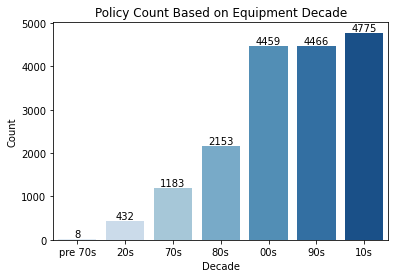

In [58]:
# equipment year - by decade
# hv_policies['EquipmentYear'].value_counts()

# Generate decade categorization
decade_list = []

for year in hv_policies['EquipmentYear']:
    if year < 1970:
        decade_list.append('pre 70s')
    elif 1970 <= year < 1980:
        decade_list.append('70s')
    elif 1980 <= year < 1990:
        decade_list.append('80s')
    elif 1990 <= year < 2000:
        decade_list.append('90s')
    elif 2000 <= year < 2010:
        decade_list.append('00s')
    elif 2010 <= year < 2020:
        decade_list.append('10s')
    elif 2020 <= year:
        decade_list.append('20s')

# Assign loss ratio categorizations
hv_policies['Decade'] = decade_list

# Group by Decade
dec_s2 = hv_policies.groupby('Decade').agg(Count=('PolicyNumber', np.count_nonzero))
dec_agg2 = dec_s2.reset_index() # convert series to df
dec_agg2.sort_values(by=['Count'], inplace=True) #sort output

# Visualize relationship
ax = sns.barplot(data=dec_agg2, x='Decade', y='Count', palette = "Blues")
ax.set(title='Policy Count Based on Equipment Decade') #set title
for i in ax.containers: #specify data labels
    ax.bar_label(i,)

High value policies primarily carry equipment from the 90s through 2010s. It's likely this naturally aligns with the distribution of equipment amongst less profitable of policies as well, so we take it with a grain of salt that older and newer equipment is more costly to insure.

<AxesSubplot:xlabel='PremValProp', ylabel='Count'>

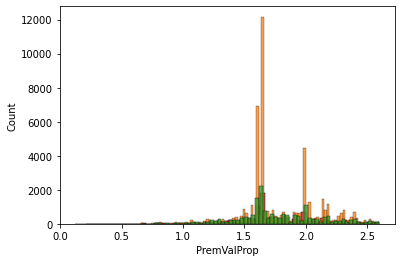

In [59]:
# # premium
# sns.histplot(data=premiums_w_claims, x='LocationPremium')
# sns.histplot(data=premiums_wo_claims, x='LocationPremium')
# sns.histplot(data=hv_policies, x='LocationPremium')

# # location / equipment value
# sns.histplot(data=premiums_w_claims, x='LocValue', color='tab:red')
# sns.histplot(data=premiums_wo_claims, x='LocValue', color='tab:orange')
# sns.histplot(data=hv_policies, x='LocValue',color='tab:green')

# PremValProp = LocationPremium / LocValue
sns.histplot(data=premiums_w_claims, x='PremValProp', color='tab:red')
sns.histplot(data=premiums_wo_claims, x='PremValProp', color='tab:orange')
sns.histplot(data=hv_policies, x='PremValProp',color='tab:green')

Whether we consider premium, location / equipment value, or PremValProp (LocationPremium / LocValue), whether high value policy, policy with or without claims, the distributions mirror each other and there's not much to be extracted with regard to these financial fields.

**Additional EDA Summary of Findings**

Our analysis of bright spots, while not Earth-shattering, did turn up a few insights that may prove fruitful in driving a higher value portfolio:

1. Certain counties (ie. Kearney, Adams, Sherman, and Lincoln) appear to be more favorable for high value operations.
2. Higher deductible plans are correlated with higher value policies.
3. Equipment from the 1990s through 2010s is correlated with higher value policies.

**Additional Analyses of Interest**

Since time was limited for this analysis, I've listed below some additional analyses that could have been interesting:

1. Dark spot analysis: dig in to the least favorable policies. What % of policies have very unfavorable loss ratios? What would be the impact of bringing their loss ratios in-line with the median? What are the characteristics of these policies?
2. Missing EquipmentYear analysis: interpret loss ratios for all specified loss ratios and aggregations when we just consider missing `claims` and `premiums` data. Hypothesize as to why this data was missing after more deeply studying its characteristics. Quantify its impact on overall loss ratio (if it had been included).
3. Outlier claims analysis: what if I had excluded the anomalous (ie. ClaimCause = wind) claims from this analysis? what impact would this have had on our different loss ratio aggregations? 
4. Year-on-year loss ratio trend: is the portfolio improving with time? Utilize PolicyEffectiveDate and explore how business is trending year-on-year (ie. 2018 vs. 2019 vs. 2020) ...

## Conclusion

### Summary of Findings

To summarize the findings from the Aggregation & Loss Ratio calculations earlier on:

* State-wise we found very favorable loss ratios (x < 40) in WI, IL, IN, GA, MT, CO, and SC and very unfavorable loss ratios (x > 80) in MO, SD, NM, MN, and AZ.
* County-wise we found that the loss ratio was favorable in ~58% of counties (ie. Brown) and unfavorable in ~31% of counties (ie. Moody).
* When claims were filed the loss ratio was an alarming 335%. Across all number of past claims this ratio was unfavorable.
* While deductibles did not follow a linear distribution, in general higher deductibles had lower loss ratios. This point was re-iterated during our bright spot analysis (EDA).
* Insuring equipment from the most recent and furthest past decades is most costly. This point was also re-iterated during our bright spot analysis (EDA).

### Recommended Underwriting Changes

The following recommendations are based on preceding sections which were succinctly summarized above:

* Expand operations, up-sell, and otherwise seek new clientele in locations where loss ratios are favorable (ie. state: WI, county: Brown).
* Increase premiums to a level that brings the loss ratio below 60% or cease policies in locations where loss ratios are unfavorable (ie. state: AZ, county: Moody).
* Diversify the portfolio by converting or on-boarding more customers to high deductible policies.
* Increase premiums in a stepwise fashion based on claim magnitude (dollar amount) and frequency (# of past claims).
* Cease policy offerings on equipment from prior to the 1970s and increase premiums by >= 20% on modern equipment (ie. year >= 2020).
